# Imports

In [1]:
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
from abacusnbody.data.read_abacus import read_asdf
import h5py
import os

import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

from scipy.spatial import KDTree, cKDTree
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata, UnivariateSpline, interp1d
from scipy.integrate import quad
from scipy.optimize import linear_sum_assignment, curve_fit

from collections import Counter
from pycorr import TwoPointCorrelationFunction, TwoPointCounter

import psutil
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
import gc
import pickle

import importlib
import functions
importlib.reload(functions)
from functions import *

## Halos

In [2]:
compaso_dir = '/global/cfs/cdirs/desi/cosmosim/Abacus/AbacusSummit_highbase_c000_ph100'

str_z = 'z0.500'
cols = ['id', 'x_L2com', 'v_L2com', 'N', 'npstartA', 'npoutA', 'npstartB', 'npoutB', 'ntaggedA', 'ntaggedB', 'r100_L2com']

path_to_sim = os.path.join(compaso_dir, "halos", str_z)
hcat = CompaSOHaloCatalog(path_to_sim, fields=cols, cleaned=True)

In [ ]:
# # Chargement des fichiers pid_A
# halo_pid_A_dir = os.path.join(path_to_sim, "halo_pid_A")
# halo_pid_A_files = [os.path.join(halo_pid_A_dir, f) for f in sorted(os.listdir(halo_pid_A_dir)) if f.endswith('.asdf')]

# all_pids_A = []
# for f in halo_pid_A_files:
#     data = read_asdf(f)
#     all_pids_A.append(data['pid'])
# all_pids_A = np.concatenate(all_pids_A)
# print(f"Particules A : {len(all_pids_A):,}")

# # Chargement des fichiers pid_B
# halo_pid_B_dir = os.path.join(path_to_sim, "halo_pid_B")
# halo_pid_B_files = [os.path.join(halo_pid_B_dir, f) for f in sorted(os.listdir(halo_pid_B_dir)) if f.endswith('.asdf')]

# all_pids_B = []
# for f in halo_pid_B_files:
#     data = read_asdf(f)
#     all_pids_B.append(data['pid'])
# all_pids_B = np.concatenate(all_pids_B)
# print(f"Particules B : {len(all_pids_B):,}")

Particules A : 476,807,235


In [4]:
# # Choisir 1000 indices aléatoires parmi tous les halos
# indices = np.random.choice(len(hcat.halos), size=1000, replace=False)
# halos_subset = hcat.halos[indices]

# from collections import defaultdict
# halo_to_particles = dict()
# halo_to_particles_tagged = dict()

# for i, halo in enumerate (halos_subset) :
#     # Subsample A
#     startA = halo['npstartA']
#     countA = halo['npoutA']
#     taggedA=halo['ntaggedA']
#     pids_A = all_pids_A[startA : startA + countA]
#     pids_A_tagged = all_pids_A[startA : startA + taggedA]

#     # Subsample B
#     startB = halo['npstartB']
#     countB = halo['npoutB'] 
#     taggedB=halo['ntaggedB']
#     pids_B = all_pids_B[startB : startB + countB]
#     pids_B_tagged = all_pids_B[startB : startB + taggedB]

#     # Union des deux sous-échantillons
#     all_pids_halo = np.concatenate( [pids_A, pids_B])
#     all_pids_halo_tagged = np.concatenate( [pids_A_tagged, pids_B_tagged])

#     # Associer au halo_id
#     halo_id = halo['id']
#     halo_to_particles[halo_id] = set(all_pids_halo)
#     halo_to_particles_tagged[halo_id] = set(all_pids_halo_tagged)
    
# # Afficher un exemple
# example_id = list(halo_to_particles.keys ()) [3]
# print(f"Exemple de halo : {example_id}")
# print(f"→ {len (halo_to_particles[example_id])} particules spout")
# print(f"→ {len (halo_to_particles_tagged[example_id])} particules tagged", '\n')

# print(f"N total du halo : {halo['N']}")
# print(f"poutA : {halo['npoutA']}")
# print(f"taggedA : {halo['ntaggedA']}")

Exemple de halo : 13702360748001000
→ 68 particules spout
→ 64 particules tagged 

N total du halo : 80
poutA : 2
taggedA : 2


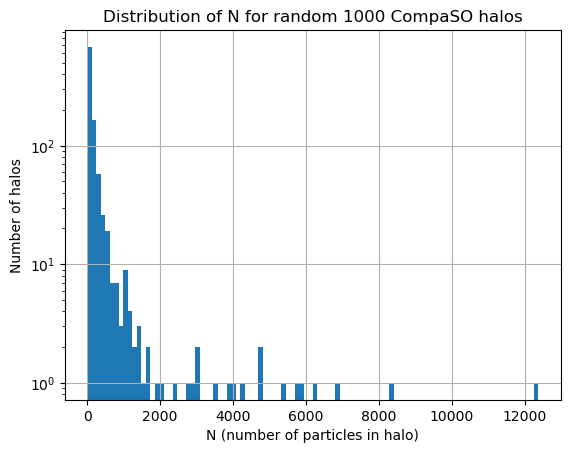

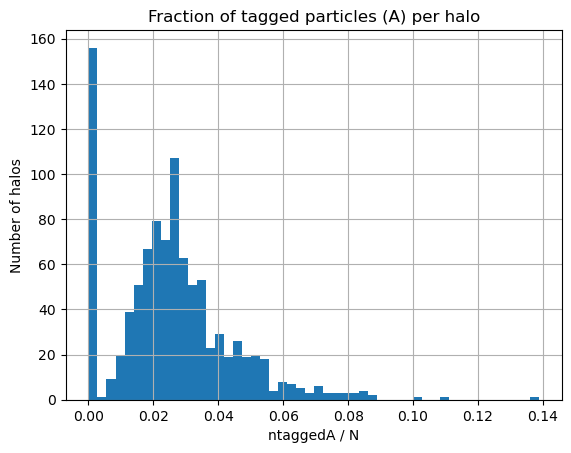

In [5]:
# plt.hist(halos_subset['N'], bins=100, log=True)
# plt.xlabel("N (number of particles in halo)")
# plt.ylabel("Number of halos")
# plt.title("Distribution of N for random 1000 CompaSO halos")
# plt.grid(True)
# plt.show()

# mask = halos_subset['N'] > 0
# ratios = halos_subset['ntaggedA'][mask] / halos_subset['N'][mask]
# plt.hist(ratios, bins=50)
# plt.xlabel("ntaggedA / N")
# plt.ylabel("Number of halos")
# plt.title("Fraction of tagged particles (A) per halo")
# plt.grid(True)
# plt.show()

Loi ajustée : ntaggedA ≈ 0.030 × N^0.984


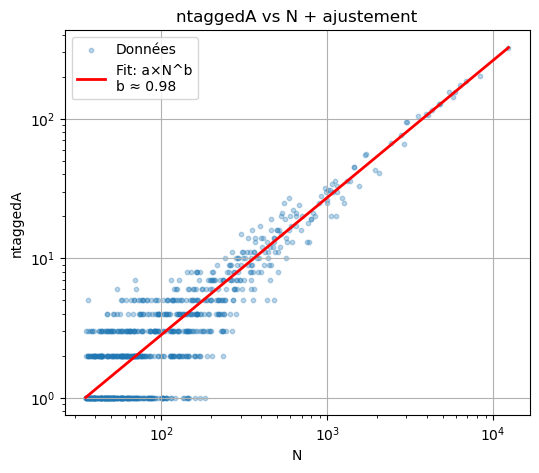

In [6]:
# # Filtrage des halos valides
# mask = halos_subset['N'] > 0

# N = halos_subset['N'][mask]
# ntagged = halos_subset['ntaggedA'][mask]


# # Modèle : loi puissance
# def power_law(N, a, b):
#     return a * N**b

# # Ajustement sur log-log
# popt, pcov = curve_fit(power_law, N, ntagged, bounds=([0, 0], [np.inf, 1.5]))

# a, b = popt
# print(f"Loi ajustée : ntaggedA ≈ {a:.3f} × N^{b:.3f}")

# N_fit = np.logspace(np.log10(min(N)), np.log10(max(N)), 200)
# ntagged_fit = power_law(N_fit, a, b)

# plt.figure(figsize=(6, 5))
# plt.scatter(N, ntagged, alpha=0.3, s=10, label='Données')
# plt.plot(N_fit, ntagged_fit, color='red', lw=2, label=f'Fit: a×N^b\nb ≈ {b:.2f}')
# plt.xscale('log')
# plt.yscale('log') 
# plt.xlabel("N")
# plt.ylabel("ntaggedA") 
# plt.title("ntaggedA vs N + ajustement")
# plt.legend()
# plt.grid(True)
# plt.show()

In [3]:
rockstar_dir = "/global/cfs/cdirs/desi/cosmosim/Abacus/supplemental/AbacusSummit_highbase_c000_ph100/rockstar/z0.500/"
# Liste des fichiers dans le répertoire
rockstar_files = [os.path.join(rockstar_dir, f) for f in os.listdir(rockstar_dir) if f.endswith('.h5')]

In [4]:
fpath = "/global/cfs/cdirs/desi/cosmosim/Abacus/supplemental/AbacusSummit_highbase_c000_ph100/rockstar/z0.500/z0.500_halo_info.npy"
data = np.load(fpath, allow_pickle=True)

print(type(data))
if isinstance(data, np.ndarray) and data.dtype.names:
    print("Colonnes :", data.dtype.names)
    print("Extrait :")
    print(data[:5])
else:
    print("Contenu brut :", data[:5])

<class 'numpy.ndarray'>
Colonnes : ('id', 'parent_id', 'pos', 'm', 'm_SO', 'r', 'vmax', 'vmax_r', 'halfmass_radius', 'rvmax', 'alt_m', 'alt_m_SO', 'rs', 'klypin_rs')
Extrait :
[(677156,     -1, [178.12808 , 147.8464  ,  96.96727 ], 1.0334500e+11, 1.0334500e+11, 102.56645, 110.42144 , 0.14898309, 27.926607, 30.132078 , [9.49086700e+10, 8.01450967e+10, 7.59269376e+10, 5.90542807e+10], [1.1599948e+11, 9.2799590e+10, 7.5926938e+10, 5.9054281e+10],  4.836068 ,  4.836068 )
 (677157,     -1, [178.31633 , 148.22392 ,  96.906425], 5.6945201e+10, 5.6945201e+10,  86.73086,  92.27557 , 0.11901365, 27.603626,  3.1961608, [5.48361175e+10, 5.27270380e+10, 4.85088748e+10, 2.53089792e+10], [5.6945201e+10, 5.4836118e+10, 5.0617958e+10, 2.5308979e+10],  4.2620244,  4.2620244)
 (677158,     -1, [178.98286 , 147.77031 ,  96.26295 ], 2.5308979e+10, 2.9527140e+10,  67.02594,  59.897026, 0.08082736, 28.214487, 34.135334 , [2.53089792e+10, 2.53089792e+10, 2.10908160e+10, 0.00000000e+00], [3.1636222e+10, 2.9527

## Masses

In [ ]:
## CompaSo

Mhalos_CS =  hcat.header['ParticleMassHMsun']*hcat.halos['N']

mask = Mhalos_CS > 0
hcat_pos = hcat.halos[mask]
Mhalos_CS = Mhalos_CS[mask]

boxsize_cs = hcat.header['BoxSize']
print("Box size CompaSo:", boxsize_cs)

Box size CompaSo: 1000.0


: 

In [ ]:
Mhalos_RS = []
ids_RS = []
num_particles_RS = []
radi_RS = []
positions_RS = []
velocities_RS = []
parent_ids_RS = []

for file in rockstar_files:
    with h5py.File(file, 'r') as f:
        # Only useful columns
        Mhalos_RS.append(f['halos']['m'][:] )
        ids_RS .append(f['halos']['id'][:])
        num_particles_RS.append(f['halos']['N'][:]) 
        positions_RS.append(f['halos']['pos'][:]) 
        velocities_RS.append(f['halos']['vel'][:]) 
        parent_ids_RS.append(f['halos']['parent_id'][:])
        radi_RS.append(f['halos']['r'][:])
        

# Combine the results
Mhalos_RS = np.concatenate(Mhalos_RS)
ids_RS = np.concatenate(ids_RS)
num_particles_RS = np.concatenate(num_particles_RS)
positions_RS = np.concatenate(positions_RS)
velocities_RS = np.concatenate(velocities_RS)
parent_ids_RS = np.concatenate(parent_ids_RS)
radi_RS = np.concatenate(radi_RS)

print(len(Mhalos_RS))

In [11]:
halos_rs = {
    'm': Mhalos_RS,
    'id': ids_RS,
    'N': num_particles_RS,
    'pos': positions_RS,
    'vel': velocities_RS,
    'parent_id': parent_ids_RS,
    'r': radi_RS
}

In [ ]:
print(halos_rs.keys())

dict_keys(['m', 'id', 'N', 'pos', 'vel', 'parent_id', 'r'])


In [13]:
print(len(Mhalos_RS))
print(len(Mhalos_CS))

107967449
48359672


## Particles

In [14]:
# ## CompaSo

# # Paths to particle files
# field_particle_dirs = [os.path.join(compaso_dir, "halos", str_z, "field_rv_A"),
#                        os.path.join(compaso_dir, "halos", str_z, "field_rv_B")]

# field_particle_files = [os.path.join(d, f) for d in field_particle_dirs for f in os.listdir(d) if f.endswith(".asdf")]

# print(f"Total files to process: {len(field_particle_files)}")

# batch_size = 2

# file_path = "/pscratch/sd/g/guittonm/all_positions.npy"

# # Same positions for both simulations
# positions_mm = np.load(file_path, mmap_mode='r')  # mmap_mode for huge data
# print(f"Total positions : {positions_mm.shape[0]}")

# Mass study

In [15]:
colors_list = ['green', 'red'] 
colors_ratio=['blue']
labels_name = ['CompaSO', 'Rockstar']
labels_scale = ['Linear', 'Log']
labels_ratio = ['Rockstar / Compaso']

## Bins

In [16]:
# Linear bins
bins = np.histogram_bin_edges(np.concatenate([Mhalos_RS, Mhalos_CS]), bins=50)

# Show bins
min_min_mass = min(Mhalos_RS.min(), Mhalos_CS.min())
max__max_mass = max(Mhalos_RS.max(), Mhalos_CS.max())

bins_log_tot = np.logspace(np.log10(min_min_mass), np.log10(max__max_mass), num=50)
bins_log_centers_tot = 0.5 * (bins_log_tot[:-1] + bins_log_tot[1:])

# Logarithmic bins
min_mass = max(Mhalos_RS.min(), Mhalos_CS.min())
max_mass = 10**14.5

bins_log = np.logspace(np.log10(min_mass), np.log10(max_mass), num=30)
bins_log_centers = 0.5 * (bins_log[:-1] + bins_log[1:])

print(f"Minimum log bins : {bins_log[0]:.2e}")
print(f"Max log bins : {bins_log[29]:.2e}")

Minimum log bins : 7.38e+10
Max log bins : 3.16e+14


In [17]:
mask_CS = (Mhalos_CS > bins_log[0]) & (Mhalos_CS < bins_log[-1])
mask_RS = (Mhalos_RS > bins_log[0]) & (Mhalos_RS < bins_log[-1])

print("Halos CS in bins:", np.sum(mask_CS))
print("Halos RS in bins:", np.sum(mask_RS))
print("Ratio inside bins:", np.sum(mask_RS) / np.sum(mask_CS))

Halos CS in bins: 47187140
Halos RS in bins: 54050273
Ratio inside bins: 1.1454449877657344


## HMF

In [18]:
hmf_rs_log_tot, bin_centers_rs_log_tot = compute_hmf(Mhalos_RS, bins_log_tot)
hmf_cs_log_tot, bin_centers_cs_log_tot = compute_hmf(Mhalos_CS, bins_log_tot)

hmf_rs_log, bin_centers_rs_log = compute_hmf(Mhalos_RS, bins_log)
hmf_cs_log, bin_centers_cs_log = compute_hmf(Mhalos_CS, bins_log)

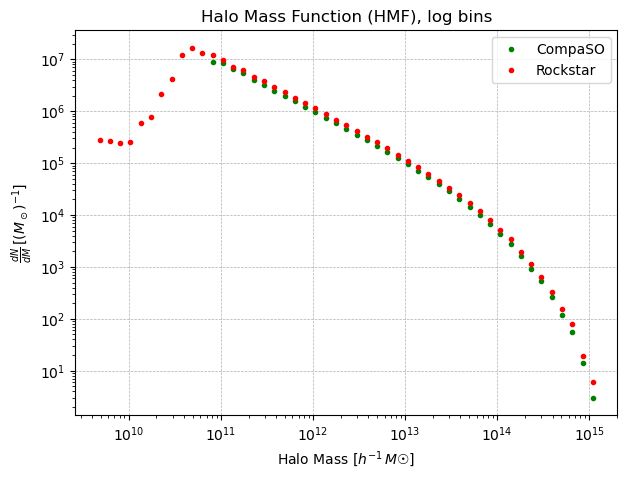

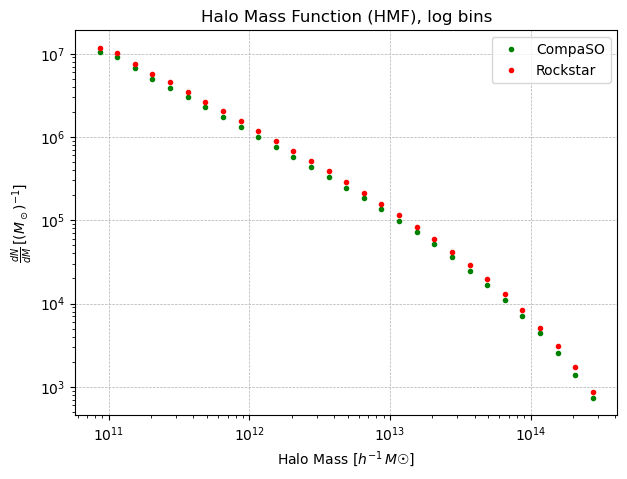

In [19]:
data_hmf_tot = [hmf_cs_log_tot, hmf_rs_log_tot]
bins_hmf_tot = [bin_centers_cs_log_tot, bin_centers_rs_log_tot]

plot_masses_fct(data_hmf_tot, bins_hmf_tot, colors_list, labels_name, linestyles_list=['none','none'], title='Halo Mass Function (HMF), log bins', ylabel=r'$\frac{dN}{dM} \, [(M_\odot)^{-1}]$')

data_hmf = [hmf_cs_log, hmf_rs_log]
bins_hmf = [bin_centers_cs_log, bin_centers_rs_log]

plot_masses_fct(data_hmf, bins_hmf, colors_list, labels_name, linestyles_list=['none','none'], title='Halo Mass Function (HMF), log bins', ylabel=r'$\frac{dN}{dM} \, [(M_\odot)^{-1}]$')

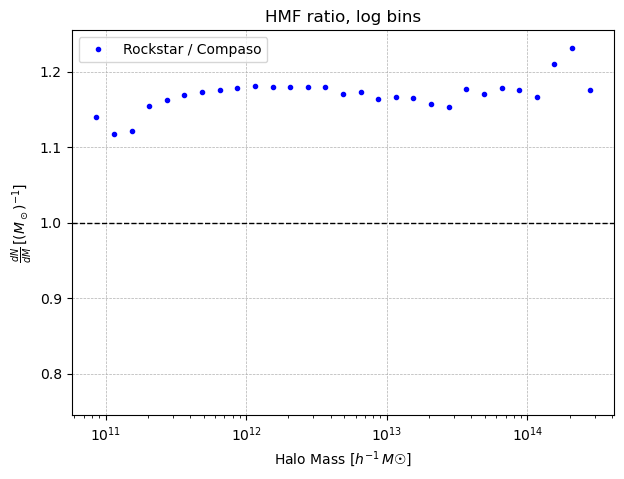

In [20]:
plot_masses_fct([hmf_rs_log / hmf_cs_log], 
                [bin_centers_rs_log], colors_list=colors_ratio, 
                labels_list=labels_ratio, linestyles_list=['none'], 
                scale='semilogx', title='HMF ratio, log bins', 
                ylabel=r'$\frac{dN}{dM} \, [(M_\odot)^{-1}]$',
                center_around_one=True, margin_factor=0.1)

# Recalibration

In [21]:
halos_rs_masked = {
    key: halos_rs[key][mask_RS] for key in halos_rs
}

# Identification des sous-halos_rs_masked
is_subhalo = halos_rs_masked['parent_id'][:] != -1
is_parent = halos_rs_masked['parent_id'][:] == -1

parent_ids = halos_rs_masked['id'][is_parent]
parent_pos_array = halos_rs_masked['pos'][is_parent]
parent_r_array = halos_rs_masked['r'][is_parent]

parent_id_to_index = {pid: idx for idx, pid in enumerate(parent_ids)}

subhalo_indices = np.where(is_subhalo)[0]
parent_found = 0

promoted_subhalos_ring = []
promoted_subhalos_outside = []

from time import time
import sys

start_time = time()
report_every = 100000  # affiche tous les 100 000 halos

for count, i in enumerate(subhalo_indices):
    if count % report_every == 0:
        elapsed = time() - start_time
        print(f"{count} sous-halos traités, {parent_found} parents trouvés — {elapsed:.1f} sec", flush=True)

    pid = halos_rs_masked['parent_id'][i]

    if pid not in parent_id_to_index:
        continue  # Parent manquant
    parent_found += 1

    pidx = parent_id_to_index[pid]
    sub_pos = halos_rs_masked['pos'][i] 
    parent_pos = parent_pos_array[pidx]
    parent_radius = parent_r_array[pidx]

    dist = np.linalg.norm(sub_pos - parent_pos)

    if 0.8 * parent_radius <= dist <= 1.0 * parent_radius:
        promoted_subhalos_ring.append(i)
    elif dist > 1.0 * parent_radius:
        promoted_subhalos_outside.append(i)

# Liste finale : parents + sous-halos proches + sous-halos extérieurs
final_indices = (
    np.where(is_parent)[0].tolist()
    + promoted_subhalos_ring
    + promoted_subhalos_outside
)

# Extraction des halos sélectionnés
# halos_rs_masked_selected = {key: halos_rs_masked[key][final_indices] for key in halos_rs_masked.keys()}
keys_light = ['id', 'pos', 'r', 'm', 'N', 'vel', 'parent_id']
halos_rs_selected = {
    key: np.take(halos_rs_masked[key], final_indices, axis=0) for key in keys_light
}

# Stats utiles
print(f"Parents        : {np.sum(is_parent)}")
print(f"Promus 0.8–1.0 : {len(promoted_subhalos_ring)}")
print(f"Promus > 1.0   : {len(promoted_subhalos_outside)}")
print(f"Total sélectionnés : {len(final_indices)}")

0 sous-halos traités, 0 parents trouvés — 0.0 sec
100000 sous-halos traités, 81278 parents trouvés — 0.7 sec
200000 sous-halos traités, 161683 parents trouvés — 1.3 sec
300000 sous-halos traités, 241436 parents trouvés — 1.9 sec
400000 sous-halos traités, 322372 parents trouvés — 2.6 sec
500000 sous-halos traités, 403034 parents trouvés — 3.3 sec
600000 sous-halos traités, 485112 parents trouvés — 3.9 sec
700000 sous-halos traités, 565993 parents trouvés — 4.6 sec
800000 sous-halos traités, 647141 parents trouvés — 5.3 sec
900000 sous-halos traités, 728387 parents trouvés — 6.0 sec
1000000 sous-halos traités, 810070 parents trouvés — 6.6 sec
1100000 sous-halos traités, 890552 parents trouvés — 7.3 sec
1200000 sous-halos traités, 971679 parents trouvés — 8.0 sec
1300000 sous-halos traités, 1053704 parents trouvés — 8.7 sec
1400000 sous-halos traités, 1134983 parents trouvés — 9.3 sec
1500000 sous-halos traités, 1215886 parents trouvés — 10.0 sec
1600000 sous-halos traités, 1297060 paren

In [22]:
hmf_rs_selected_log, bin_centers_rs_selected_log = compute_hmf(halos_rs_selected['m'], bins_log)

# parents halos
masses_rs_parents = halos_rs_masked['m'][is_parent]

hmf_rs_parents_log, bin_centers_rs_parents_log = compute_hmf(masses_rs_parents, bins_log)

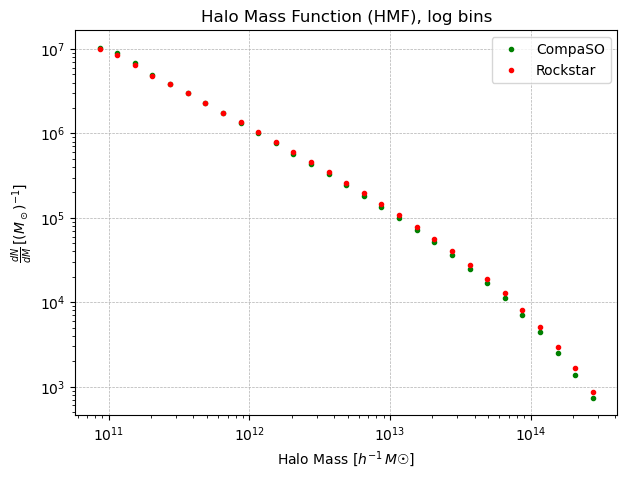

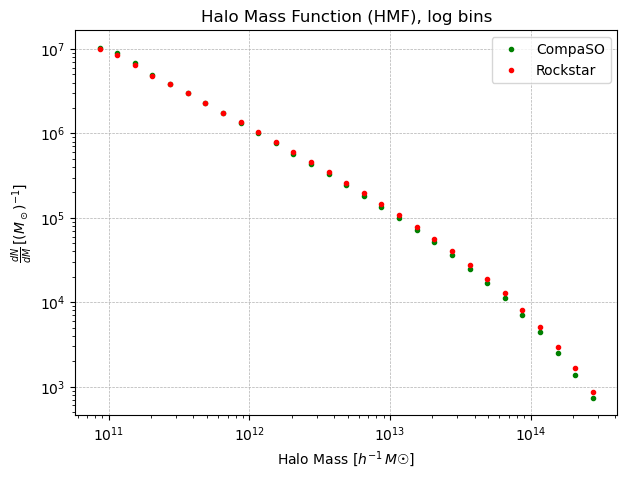

In [23]:
data_hmf_par = [hmf_cs_log, hmf_rs_parents_log]
bins_hmf_par = [bin_centers_cs_log, bin_centers_rs_parents_log]

plot_masses_fct(data_hmf_par, bins_hmf_par, colors_list, labels_name, linestyles_list=['none','none'], title='Halo Mass Function (HMF), log bins', ylabel=r'$\frac{dN}{dM} \, [(M_\odot)^{-1}]$')

data_hmf_sel = [hmf_cs_log, hmf_rs_selected_log]
bins_hmf_sel = [bin_centers_cs_log, bin_centers_rs_selected_log]

plot_masses_fct(data_hmf_sel, bins_hmf_sel, colors_list, labels_name, linestyles_list=['none','none'], title='Halo Mass Function (HMF), log bins', ylabel=r'$\frac{dN}{dM} \, [(M_\odot)^{-1}]$')

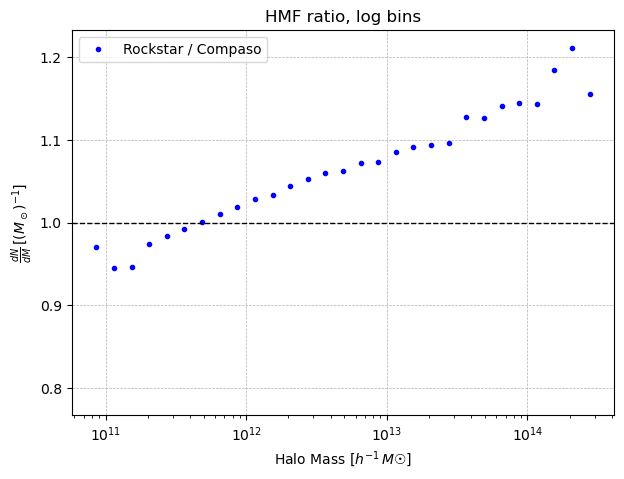

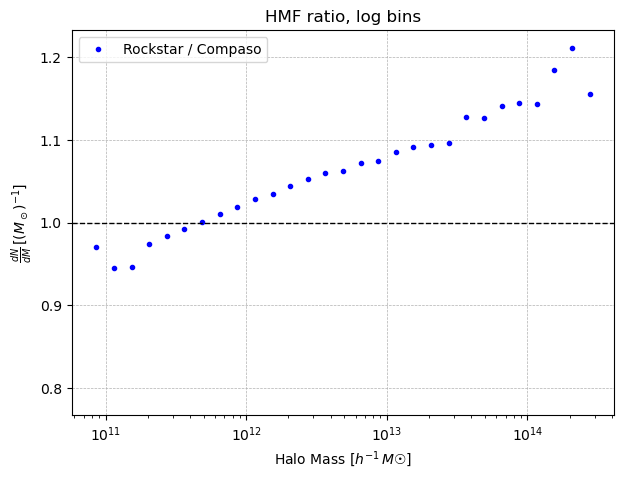

In [24]:
plot_masses_fct([hmf_rs_parents_log / hmf_cs_log], 
                [bin_centers_rs_parents_log], colors_list=colors_ratio, 
                labels_list=labels_ratio, linestyles_list=['none'], 
                scale='semilogx', title='HMF ratio, log bins', 
                ylabel=r'$\frac{dN}{dM} \, [(M_\odot)^{-1}]$',
                center_around_one=True, margin_factor=0.1)

plot_masses_fct([hmf_rs_selected_log / hmf_cs_log], 
                [bin_centers_rs_selected_log], colors_list=colors_ratio, 
                labels_list=labels_ratio, linestyles_list=['none'], 
                scale='semilogx', title='HMF ratio, log bins', 
                ylabel=r'$\frac{dN}{dM} \, [(M_\odot)^{-1}]$',
                center_around_one=True, margin_factor=0.1)

# 1-1 matching

In [42]:
## Rockstar

mass_mask_rs = (halos_rs_selected['m'] >= 5*10**11) & (halos_rs_selected['m'] <= max_mass)

halos_rs_mass_filtered = {
    key: halos_rs_selected[key][mass_mask_rs] for key in halos_rs_selected
}

positions_rs = halos_rs_mass_filtered['pos']
masses_selected_rs = halos_rs_mass_filtered['m']

## CompaSO
mass_mask_cs = (Mhalos_CS >= 5*10**11) & (Mhalos_CS <= max_mass)

positions_cs = np.array(hcat_pos['x_L2com'])[mass_mask_cs]

masses_selected_cs = Mhalos_CS[mass_mask_cs]

In [43]:
print('len pos CS', np.shape(positions_cs))
print('len pos RS', np.shape(positions_rs))

len pos CS (7778681, 3)
len pos RS (8018773, 3)


In [44]:
print('max pos CS', np.max(positions_cs), 'min pos CS', np.min(positions_cs))
print('max pos RS', np.max(positions_rs), 'min pos RS', np.min(positions_rs))

max pos CS 500.0 min pos CS -500.0
max pos RS 999.9999 min pos RS 5.6836412e-05


In [45]:
positions_cs = (positions_cs + boxsize_cs / 2) % boxsize_cs

positions_rs = positions_rs % boxsize_cs

print('max pos CS', np.max(positions_cs), 'min pos CS', np.min(positions_cs))
print('max pos RS', np.max(positions_rs), 'min pos RS', np.min(positions_rs))

max pos CS 999.9997 min pos CS 0.0
max pos RS 999.9999 min pos RS 5.6836412e-05


In [46]:
tree_rs = cKDTree(positions_rs, boxsize=boxsize_cs)
tree_cs = cKDTree(positions_cs, boxsize=boxsize_cs)

In [47]:
distances, indices_rs = tree_rs.query(positions_cs, k=1, workers=-1)  # k=1 → plus proche voisin

In [48]:
distances_back, indices_cs = tree_cs.query(positions_rs, k=1, workers=-1)

In [49]:
# Matching croisé
matched_indices = [(i, j) for i, j in enumerate(indices_rs) if indices_cs[j] == i]

In [51]:
print('Number of CompaSO halos:', f"{len(positions_cs):,}".replace(',', ' '))
print('Number of Rockstar parents halos:', f"{len(positions_rs):,}".replace(',', ' '), '\n')

print('Number of crossed-matched halos :', f"{len(matched_indices):,}".replace(',', ' '))

Number of CompaSO halos: 7 778 681
Number of Rockstar parents halos: 8 018 773 

Number of crossed-matched halos : 1 912 783


In [50]:
del tree_rs, tree_cs
gc.collect()

380

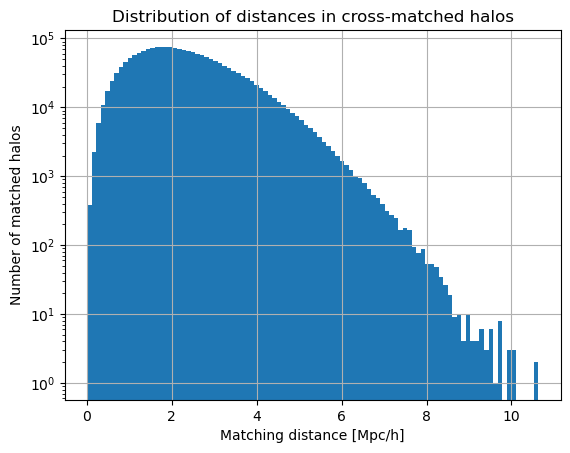

In [52]:
distances_matched = [distances[i] for i, _ in matched_indices]

plt.hist(distances_matched, bins=100)
plt.xlabel('Matching distance [Mpc/h]')
plt.ylabel('Number of matched halos')
plt.title('Distribution of distances in cross-matched halos')
plt.yscale('log')
plt.grid(True)
plt.show()

In [53]:
del distances_matched
gc.collect()

21738

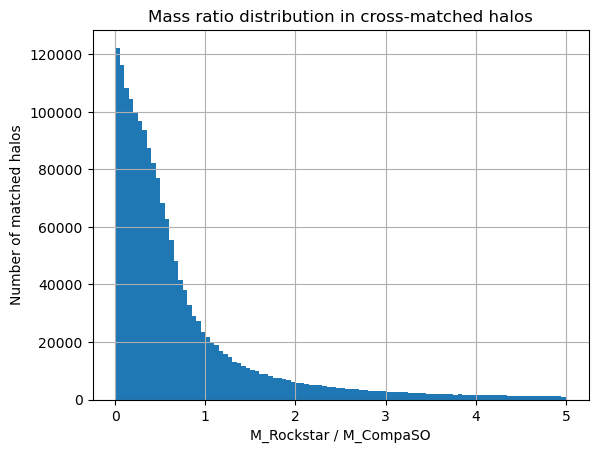

In [54]:
masses_cs_matched = np.array([Mhalos_CS[i] for i, j in matched_indices])
masses_rs_matched = np.array([Mhalos_RS[j] for i, j in matched_indices])

# Calcul du ratio
mass_ratio = masses_rs_matched / masses_cs_matched

# Histogramme
plt.hist(mass_ratio, bins=100, range=(0, 5))
plt.xlabel('M_Rockstar / M_CompaSO')
plt.ylabel('Number of matched halos')
plt.title('Mass ratio distribution in cross-matched halos')
plt.grid(True)
plt.show()

In [55]:
del indices_rs, indices_cs, masses_cs_matched, masses_rs_matched, mass_ratio
gc.collect()

9787

## Improvment of cross matching

In [56]:
mass_tolerance = 0.5
nbins_mass = 20 

min_mass_sel = max(masses_selected_cs.min(), masses_selected_rs.min())
max_mass_sel = min(masses_selected_cs.max(), masses_selected_rs.max())

mass_bins = np.logspace(np.log10(min_mass), np.log10(max_mass), nbins_mass + 1)

In [57]:
matched_indices = []  # pour stocker les (i_cs, j_rs)

for b in range(nbins_mass):
    mass_min = mass_bins[b]
    mass_max = mass_bins[b+1]

    # Sélectionner halos Rockstar dans ce bin
    mask_rs = (masses_selected_rs >= mass_min) & (masses_selected_rs < mass_max)
    pos_rs_bin = positions_rs[mask_rs]
    idx_rs_bin = np.where(mask_rs)[0]

    if len(pos_rs_bin) == 0:
        continue  # pas de halos Rockstar dans ce bin

    # Construire KDTree pour Rockstar dans ce bin
    tree_rs_bin = cKDTree(pos_rs_bin, boxsize=boxsize_cs)

    # Sélectionner halos CompaSO dans ce bin ± mass_tolerance
    mask_cs = (masses_selected_cs >= mass_min / (1 + mass_tolerance)) & (masses_selected_cs < mass_max * (1 + mass_tolerance))
    pos_cs_bin = positions_cs[mask_cs]
    idx_cs_bin = np.where(mask_cs)[0]

    if len(pos_cs_bin) == 0:
        continue  # pas de halos CompaSO dans ce bin

    # Matching spatial : CompaSO -> Rockstar
    distances, indices_rs_in_bin = tree_rs_bin.query(pos_cs_bin, k=1, workers=-1)

    # Enregistrer les correspondances (indices globaux)
    for i, j_in_bin in enumerate(indices_rs_in_bin):
        i_cs_global = idx_cs_bin[i]
        j_rs_global = idx_rs_bin[j_in_bin]
        matched_indices.append((i_cs_global, j_rs_global))

In [58]:
# Extraire les indices
i_cs_matched = np.array([i for i, j in matched_indices])
j_rs_matched = np.array([j for i, j in matched_indices])

# Extraire les masses correspondantes
masses_cs_matched = masses_selected_cs[i_cs_matched]
masses_rs_matched = masses_selected_rs[j_rs_matched]

In [59]:
del masses_selected_cs, masses_selected_rs, j_rs_matched, i_cs_matched
gc.collect()

0

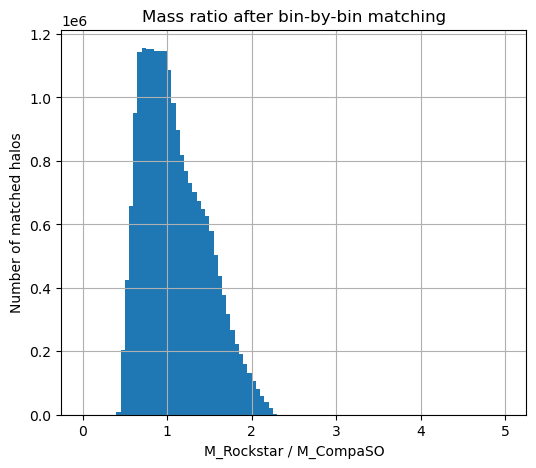

9792

In [60]:
mass_ratio = masses_rs_matched / masses_cs_matched

del masses_rs_matched, masses_cs_matched
gc.collect()

plt.figure(figsize=(6,5))
plt.hist(mass_ratio, bins=100, range=(0,5))
plt.xlabel('M_Rockstar / M_CompaSO')
plt.ylabel('Number of matched halos')
plt.title('Mass ratio after bin-by-bin matching')
plt.grid(True)
plt.show()

del mass_ratio
gc.collect()

## New test

In [61]:
radii_rs = halos_rs_mass_filtered['r']
radii_cs = hcat_pos['r100_L2com'][mass_mask_cs]

tree_rs = cKDTree(positions_rs, boxsize=boxsize_cs)
tree_cs = cKDTree(positions_cs, boxsize=boxsize_cs)

neighbors_in_rs = tree_rs.query_ball_point(positions_cs, r=radii_cs, workers=-1)
neighbors_in_cs = tree_cs.query_ball_point(positions_rs, r=radii_rs, workers=-1)

print(f"Voisins Rockstar du halo CS[42] : {neighbors_in_rs[42]}")

# # Matching croisé
# matched_indices = [(i, j) for i, j in enumerate(indices_rs) if indices_cs[j] == i]

: 